# CampaignInsight
**AUC-Optimized Mail Response Prediction Pipeline Using XGBoost and Class Imbalance Correction**

In [44]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_recall_curve,
    auc as calc_auc,
    recall_score,
    f1_score,
    precision_score

)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [45]:
mailout = pd.read_csv('data/mailout_response.csv', sep=';')


In [46]:
mailout["CAMEO_DEUG_2015"] = pd.to_numeric(mailout["CAMEO_DEUG_2015"], errors='coerce')
mailout["CAMEO_INTL_2015"] = pd.to_numeric(mailout["CAMEO_INTL_2015"], errors='coerce')


In [47]:
mailout_shuffled = mailout.sample(frac=1, replace=True, random_state=42).reset_index(drop=True)

In [48]:
def full_preprocessing_pipeline(df, label_col, id_columns=None, null_threshold=0.9):
    if id_columns:
        df = df.drop(columns=id_columns)

    # Drop columns with > null_threshold missing values
    null_ratio = df.isnull().mean()
    df = df.drop(columns=null_ratio[null_ratio > null_threshold].index)

    # Separate features and labels
    X = df.drop(columns=[label_col])
    y = df[label_col]

    # Identify numeric and categorical columns
    num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    # Preprocessing pipelines
    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
    ])

    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ])

    return preprocessor, X, y


def find_best_threshold(y_true, y_scores, metric="f1", plot=True):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)

    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)
    best_idx = np.argmax(f1s)
    best_threshold = thresholds[best_idx]
    # best_threshold = 0.07
    print(f"Best threshold (F1): {best_threshold:.4f} | F1 = {f1s[best_idx]:.4f}")

    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(thresholds, precisions[:-1], label='Precision')
        plt.plot(thresholds, recalls[:-1], label='Recall')
        plt.plot(thresholds, f1s[:-1], label='F1-score')
        plt.axvline(x=best_threshold, color='r', linestyle='--')
        plt.title("Precision, Recall and F1 vs. Threshold")
        plt.xlabel("Threshold")
        plt.ylabel("Score")
        plt.grid()
        plt.legend()
        plt.show()

    return best_threshold


def train_and_evaluate_model_auc(df,
                                 label_col='RESPONSE',
                                 id_columns=None,
                                 null_threshold=0.9,
                                 test_size=0.2,
                                 random_state=42):
    print("Step 1: Preprocessing...")
    preprocessor, X, y = full_preprocessing_pipeline(df, label_col, id_columns, null_threshold)

    print("Step 2: Train/Test Split")
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    print("Step 3: Fitting Preprocessing Pipeline")
    X_train_proc = preprocessor.fit_transform(X_train)
    X_val_proc = preprocessor.transform(X_val)

    print("Step 4: GridSearchCV for best AUC model...")
    xgb = XGBClassifier(objective='binary:logistic', eval_metric='auc',
                        scale_pos_weight=200, use_label_encoder=False,
                        device='cuda', tree_method='hist')

    param_grid = {
        'learning_rate': [0.05],
        'max_depth': [5],
        'n_estimators': [100],
        'subsample': [0.7],
        'colsample_bytree': [1.0]
    }

    grid = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=3,
        verbose=0,
        n_jobs=1
    )

    grid.fit(X_train_proc, y_train)

    best_model = grid.best_estimator_
    print(f"Best ROC AUC (CV): {grid.best_score_:.4f}")
    print(f"Best Parameters: {grid.best_params_}")

    print("Step 5: Predicting Probabilities and Finding Best Threshold")
    y_scores = best_model.predict_proba(X_val_proc)[:, 1]
    best_thresh = find_best_threshold(y_val, y_scores)

    print(f"Step 6: Evaluation with threshold = {best_thresh:.2f}")
    y_pred = (y_scores >= best_thresh).astype(int)

    print("\nROC AUC:", roc_auc_score(y_val, y_scores))
    precision, recall, _ = precision_recall_curve(y_val, y_scores)
    pr_auc = calc_auc(recall, precision)
    print("PR AUC :", round(pr_auc, 4))
    print("\nClassification Report:\n", classification_report(y_val, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))

    return best_model, preprocessor, best_thresh



In [49]:
def sweep_thresholds(y_true, y_scores, max_fp_rate=None, plot=True):


    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-6)

    results = []
    for i, thresh in enumerate(thresholds):
        y_pred = (y_scores >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        fp_rate = fp / (fp + tn + 1e-6)

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)

        if (max_fp_rate is None) or (fp_rate <= max_fp_rate):
            results.append({
                'threshold': thresh,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'fp_rate': fp_rate,
                'tp': tp,
                'fp': fp,
                'tn': tn,
                'fn': fn
            })

    df_results = pd.DataFrame(results)
    best_f1 = df_results.loc[df_results['f1'].idxmax()]

    print(f"Best F1 Threshold: {best_f1.threshold:.4f}")
    print(f"  • Precision: {best_f1.precision:.4f}")
    print(f"  • Recall   : {best_f1.recall:.4f}")
    print(f"  • F1-score : {best_f1.f1:.4f}")
    print(f"  • FP rate  : {best_f1.fp_rate:.4f}")
    print(f"  • TP / FP  : {int(best_f1.tp)} / {int(best_f1.fp)}")

    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, precisions[:-1], label='Precision')
        plt.plot(thresholds, recalls[:-1], label='Recall')
        plt.plot(thresholds, f1s[:-1], label='F1 Score')
        plt.axvline(x=best_f1.threshold, color='red', linestyle='--', label='Best Threshold')
        plt.xlabel("Threshold")
        plt.ylabel("Score")
        plt.title("Precision / Recall / F1 vs. Threshold")
        plt.grid(True)
        plt.legend()
        plt.show()

    return best_f1

def train_and_evaluate_model_auc(
    df,
    label_col='RESPONSE',
    id_columns=None,
    null_threshold=0.9,
    test_size=0.2,
    random_state=42,
    max_fp_rate=None,
    plot_thresholds=True
):
    from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, precision_recall_curve, auc
    from xgboost import XGBClassifier
    from sklearn.model_selection import train_test_split, GridSearchCV

    print("Step 1: Preprocessing...")
    preprocessor, X, y = full_preprocessing_pipeline(df, label_col, id_columns, null_threshold)

    print("Step 2: Train/Test Split")
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )

    print("Step 3: Fitting Preprocessing Pipeline")
    X_train_proc = preprocessor.fit_transform(X_train)
    X_val_proc = preprocessor.transform(X_val)

    print("Step 4: GridSearchCV for best AUC model...")
    xgb = XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        scale_pos_weight=200,
        use_label_encoder=False,
        device='cuda',
        tree_method='hist'
    )

    param_grid = {
        'learning_rate': [0.05],
        'max_depth': [5],
        'n_estimators': [100],
        'subsample': [0.7],
        'colsample_bytree': [1.0]
    }

    grid = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring='roc_auc',
        cv=3,
        verbose=0,
        n_jobs=1
    )

    grid.fit(X_train_proc, y_train)
    best_model = grid.best_estimator_

    print(f"Best ROC AUC (CV): {grid.best_score_:.4f}")
    print(f"Best Parameters: {grid.best_params_}")

    print("Step 5: Predicting Probabilities and Sweeping Thresholds")
    y_scores = best_model.predict_proba(X_val_proc)[:, 1]

    # Call external sweep_thresholds function
    best_thresh_info = sweep_thresholds(
        y_true=y_val,
        y_scores=y_scores,
        max_fp_rate=max_fp_rate,
        plot=plot_thresholds
    )

    best_thresh = best_thresh_info['threshold']
    y_pred = (y_scores >= best_thresh).astype(int)

    print(f"\nStep 6: Evaluation with threshold = {best_thresh:.2f}")
    print("ROC AUC:", roc_auc_score(y_val, y_scores))
    precision, recall, _ = precision_recall_curve(y_val, y_scores)
    pr_auc = auc(recall, precision)
    print("PR AUC :", round(pr_auc, 4))
    print("\nClassification Report:\n", classification_report(y_val, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_val, y_pred))

    return best_model, preprocessor, best_thresh


In [50]:
df_trainval, df_test = train_test_split(
    mailout_shuffled,
    test_size=0.2,
    stratify=mailout_shuffled['RESPONSE'],
    random_state=42
)


Step 1: Preprocessing...
Step 2: Train/Test Split
Step 3: Fitting Preprocessing Pipeline
Step 4: GridSearchCV for best AUC model...
Best ROC AUC (CV): 0.7832
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}
Step 5: Predicting Probabilities and Sweeping Thresholds
Best F1 Threshold: 0.8632
  • Precision: 0.5882
  • Recall   : 0.3529
  • F1-score : 0.4412
  • FP rate  : 0.0031
  • TP / FP  : 30 / 21


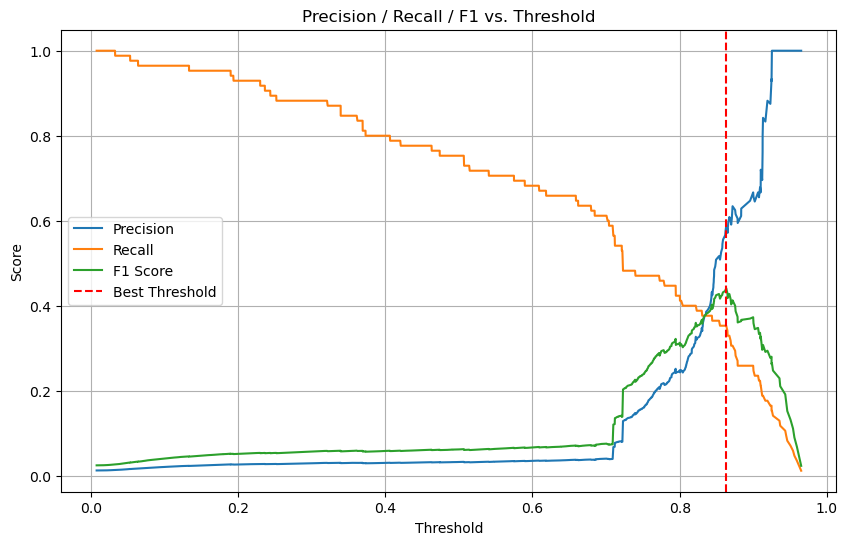


Step 6: Evaluation with threshold = 0.86
ROC AUC: 0.845026123573601
PR AUC : 0.3471

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      6789
           1       0.59      0.35      0.44        85

    accuracy                           0.99      6874
   macro avg       0.79      0.67      0.72      6874
weighted avg       0.99      0.99      0.99      6874


Confusion Matrix:
 [[6768   21]
 [  55   30]]


In [51]:
model, preprocessor, best_thresh = train_and_evaluate_model_auc(
    df_trainval,
    label_col='RESPONSE',
    id_columns=['LNR'],  # or whatever your ID column is
    null_threshold=0.9,
    max_fp_rate=0.10,
    plot_thresholds=True
)


In [52]:
def evaluate_on_test(df_test, model, preprocessor, threshold, label_col='RESPONSE', id_columns=None):
    from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

    # Drop ID and label
    X_test = df_test.drop(columns=[label_col] + (id_columns or []))
    y_test = df_test[label_col]

    # Preprocess
    X_test_proc = preprocessor.transform(X_test)

    # Predict scores
    y_scores = model.predict_proba(X_test_proc)[:, 1]
    y_pred = (y_scores >= threshold).astype(int)

    # Evaluate
    roc = roc_auc_score(y_test, y_scores)
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)

    print(f"\nEvaluation on Unseen Test Data (threshold = {threshold:.2f})")
    print("ROC AUC:", round(roc, 4))
    print("PR AUC :", round(pr_auc, 4))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    return roc, pr_auc


In [53]:
evaluate_on_test(
    df_test,
    model=model,
    preprocessor=preprocessor,
    threshold=best_thresh,
    label_col='RESPONSE',
    id_columns=['LNR']
)



Evaluation on Unseen Test Data (threshold = 0.86)
ROC AUC: 0.8446
PR AUC : 0.3632

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      8486
           1       0.55      0.34      0.42       107

    accuracy                           0.99      8593
   macro avg       0.77      0.67      0.71      8593
weighted avg       0.99      0.99      0.99      8593

Confusion Matrix:
 [[8456   30]
 [  71   36]]


(0.8445912013409662, 0.3631717561807861)